# <span style="color:red">Importing Data and getting initial info</span>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

from unidecode import unidecode
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from wordcloud import WordCloud
from string import punctuation

# UNCOMMENT THIS PART WHEN RUNNING THIS NOTEBOOK FOR THE FIRST TIME
# nltk.download() 

In [2]:
data = pd.read_csv("./data/feed_2020-02-24.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
Id              1000 non-null int64
Title           1000 non-null object
Image           1000 non-null object
Link            1000 non-null object
Category        1000 non-null object
Content         1000 non-null object
Created at      1000 non-null object
Updated at      1000 non-null object
Button text     997 non-null object
Pick count      1000 non-null int64
Collectible     1000 non-null bool
Published at    1000 non-null object
Platform        1000 non-null object
dtypes: bool(1), int64(2), object(10)
memory usage: 94.9+ KB


# <span style="color:red">Data Pre-processing</span>

In [4]:
feed_news = data.query('Category == "news"').copy()
feed_news = feed_news[['Id', 'Title', 'Content']]

### Creating a column with title and content together

In [5]:
feed_news['Title_and_Content'] = feed_news['Title'] + ' ' + feed_news['Content']

### Transforming text to lower_case

In [6]:
feed_news['Title_and_Content'] = feed_news['Title_and_Content'].str.lower()

### Removing stopwords

In [7]:
pattern = r'\b(?:{})\b'.format('|'.join(stopwords.words('portuguese'))) 
feed_news['Without_stopwords'] = feed_news['Title_and_Content'].str.replace(pattern, '')

### Removing punctuations

In [8]:
punctuations = [p for p in punctuation]

In [9]:
def remove_punctuations(text):    
    tokenizer = WordPunctTokenizer()
    words = tokenizer.tokenize(text)

    for word in words:
        words.remove(word) if word in punctuations else None

    return ' '.join(words)

In [10]:
feed_news['Without_punctuations'] = feed_news['Without_stopwords'].apply(remove_punctuations)

### Removing accents

In [11]:
def remove_accents(text):
    return unidecode(text)

In [12]:
feed_news['Without_accents'] = feed_news['Without_punctuations'].apply(remove_accents)

### Removing morphological affixes from words (Stemmer)

In [13]:
def stem_words(text):    
    tokenizer = WordPunctTokenizer()
    stemmer = RSLPStemmer()
    words = tokenizer.tokenize(text)
    stemmed_words = map(lambda word : stemmer.stem(word), words)

    return ' '.join(stemmed_words)

In [14]:
feed_news['Without_morphological_affixes'] = feed_news['Without_accents'].apply(stem_words)

# <span style="color:red">WordClouds</span>

### Function to generate wordclouds given a text

In [15]:
def generate_wordcloud(text, figsize=(20,8)):
    wordcloud = WordCloud(max_words=100, 
                          width=700,
                          height=500,
                          max_font_size=110,
                          collocations=False).generate(text)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Function to get the full content and title in one string

In [16]:
def full_content_and_title(series):
    return series.str.cat(sep=" ")

### For raw data

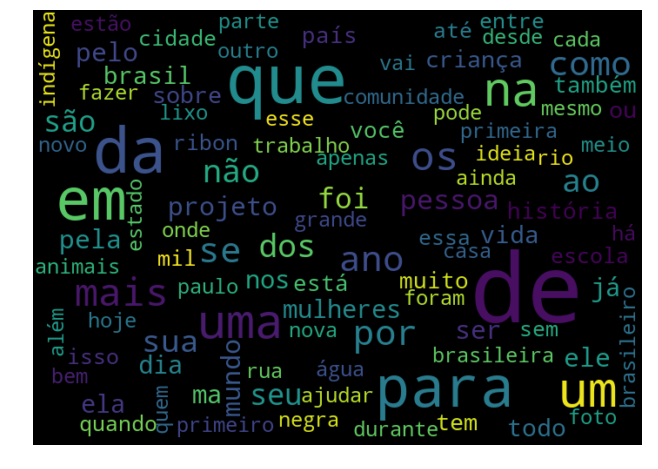

In [17]:
text = full_content_and_title(feed_news['Title_and_Content'])

generate_wordcloud(text)

### Without stop  words

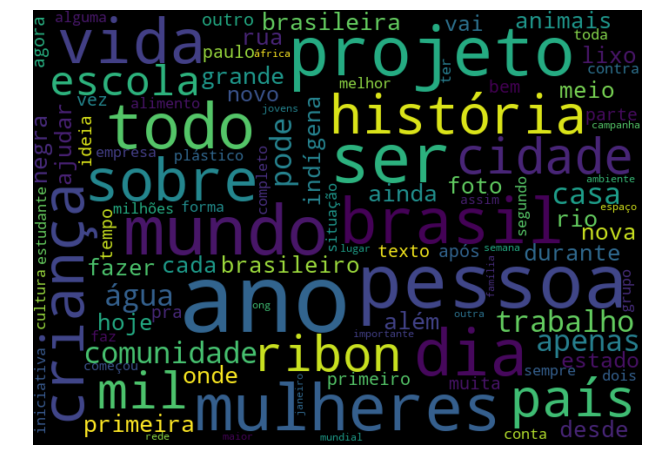

In [18]:
text = full_content_and_title(feed_news['Without_stopwords'])

generate_wordcloud(text)

### Without punctuations

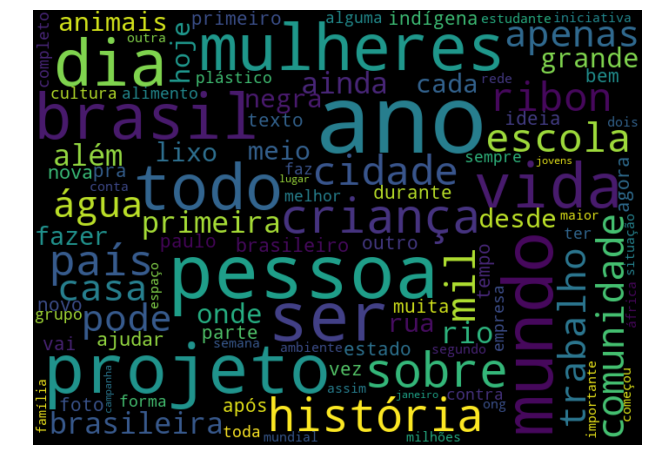

In [19]:
text = full_content_and_title(feed_news['Without_punctuations'])

generate_wordcloud(text)

### Without accents

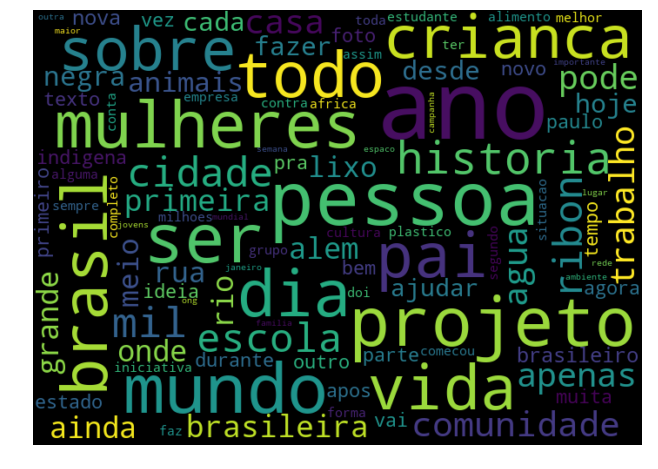

In [20]:
text = full_content_and_title(feed_news['Without_accents'])
generate_wordcloud(text)

### Without morphological affixes (Stemmed)

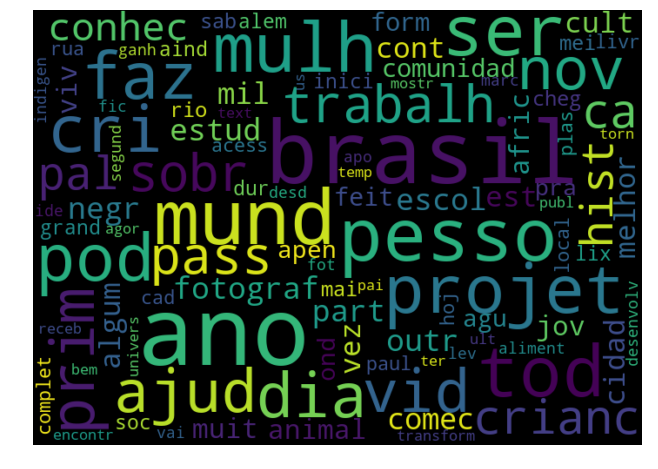

In [21]:
text = full_content_and_title(feed_news['Without_morphological_affixes'])
generate_wordcloud(text)